# Toxicity Target Type Classification

In this notebook, we will train a baseline model to predict the type of a targeted toxic comment.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In the first cell, we set the `KAGGLE_USERNAME` and `KAGGLE_KEY` environment variables. We also import the required packages.

In [1]:
import os

os.environ["KAGGLE_USERNAME"] = None
os.environ["KAGGLE_KEY"] = None

import shutil
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from simpletransformers.classification import (
    ClassificationModel,
    ClassificationArgs
)

%matplotlib inline

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

seed = 1993

In the next cell, we will remove some folders used by `simpletransformers`.

In [2]:
temp_folders = ["cache_dir", "outputs", "runs"]

for folder in temp_folders:
    if os.path.exists(folder):
        shutil.rmtree(folder, ignore_errors=True)

## Functions

In this section, we will define some helper functions.

In [3]:
def prep_data(X: List[str], Y: List[int], classes: Dict[Any, int]):
    """
    Prepare data (X, y) in a list.

    Args:
    - X: list of strings (texts)
    - y: List of ints (0 or 1)
    - classes: dictionary of classess ({class_id: class_name, ...})

    Returns:
        List of data.
    """

    def get_key_by_value(dictionary, value):
        "Get key by value in dictionary"
        return next(key for key, val in dictionary.items() if val == value)

    data = []
    for x, y in zip(X, Y):
        y = get_key_by_value(classes, y)
        data.append([x, y])
    return data

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [5]:
if not os.path.exists("olidbr.csv"):
    print("Downloading data from Kaggle")
    kaggle = KaggleApi()
    kaggle.authenticate()
    kaggle.dataset_download_file(dataset="olidbr", file_name="olidbr.csv")

df = pd.read_csv("olidbr.csv")

print(f"Shape: {df.shape}")
df.head()

Shape: (711, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


We need to filter only targeted toxic comments.

In [6]:
df = df[(df["is_offensive"] == "OFF") & (df["is_targeted"] == "TIN")]
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape}")

Shape: (304, 17)


## Explorative analysis

In the second cell, we load the data and perform an exploratory analysis.

In [7]:
df_eda = df[["text", "targeted_type"]].groupby("targeted_type").count()
df_eda.reset_index(inplace=True)
df_eda

,targeted_type,text
0,GRP,59
1,IND,241
2,OTH,4


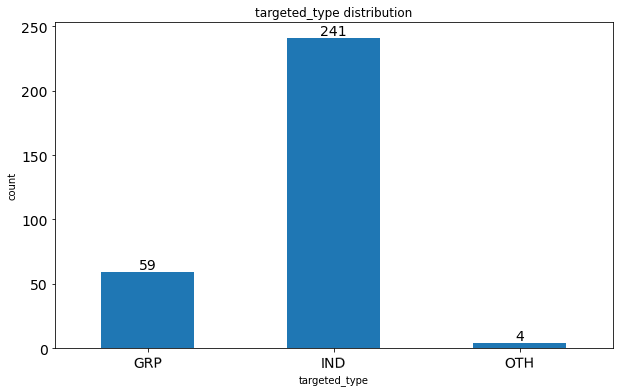

In [8]:
ax = df_eda.plot(x="targeted_type", y="text", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="targeted_type", ylabel="count", fontsize=14,
                 rot=1, title="targeted_type distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

In [9]:
classes = {
    0: "IND",
    1: "GRP",
    2: "OTH"
}

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [10]:
df = df[["text", "targeted_type"]]

X = df["text"].values
y = df["targeted_type"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=seed,
                                                    stratify=y)

train_data = prep_data(X_train, y_train, classes)
test_data = prep_data(X_test, y_test, classes)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")


train_data: (212, 2)
test_data: (92, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [11]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=6)

# Create a ClassificationModel
model = ClassificationModel(
    model_type="bert",
    model_name="neuralmind/bert-base-portuguese-cased",
    num_labels=3,
    args=model_args,
    weight=list(class_weights),
    use_cuda=False
)

# Train the model
model.train_model(df_train)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

(270, 0.25501523862239317)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;
- **ROC AUC**: the area under the receiver operating characteristic Curve (ROC AUC).

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  1%|          | 1/92 [00:18<27:34, 18.19s/it]
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2
Running Evaluation: 100%|██████████| 12/12 [00:19<00:00,  1.58s/it]
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5336444268219744, 'eval_loss': 0.8393683316923367}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
100%|██████████| 12/12 [00:17<00:00,  1.44s/it]


In [13]:
print(classification_report(y_true, y_pred, digits=4,
                            target_names=classes.values()))

              precision    recall  f1-score   support

         IND     0.8846    0.9452    0.9139        73
         GRP     0.7143    0.5556    0.6250        18
         OTH     0.0000    0.0000    0.0000         1

    accuracy                         0.8587        92
   macro avg     0.5330    0.5003    0.5130        92
weighted avg     0.8417    0.8587    0.8474        92



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Testing the model

In the last section, we will test the model with some comments from the test set.

In [14]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred.head(10)["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


,text,labels,predictions
0,"RT USER: O que mudou, muffin fecal? USER URL",IND,IND
1,USER Assassinos,IND,GRP
2,USER PSDB genocida,IND,IND
3,USER USER USER USER Pau no seus cus,IND,IND
4,USER Acabar com o bolsoMoroNazismo NARCOEVANGÉ...,IND,GRP
5,USER USER USER USER Os mbls com suas irmãs e s...,GRP,IND
6,"USER Um safado, assim como toda a turma dele (...",IND,IND
7,USER Corrupto. Ainda vou ver vc cair ..... jun...,IND,IND
8,USER Esse bandido deveria ter sido preso.,IND,IND
9,USER Vau toma no cu seu filho da puta URL,IND,IND
